In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [488]:
import os
this_directory = os.path.realpath(".")
home_directory = os.path.split(this_directory)[0]
data_directory = os.path.join(home_directory, "data")
images_directory = os.path.join(home_directory, "images")
demo_dir = os.path.join(images_directory, 'demography')

In [443]:
features = pd.read_pickle("{}/qozs_features.pkl".format(data_directory))
features.reset_index(inplace=True, drop=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 16 columns):
population_total           8685 non-null float64
age_median                 8682 non-null float64
p_never_married            8685 non-null float64
p_white                    8685 non-null float64
p_black                    8685 non-null float64
poverty                    8685 non-null float64
household_income_median    8657 non-null float64
home_value_median          8382 non-null float64
structure_year_median      8661 non-null float64
outofcountyflux            7822 non-null float64
p_renting                  8679 non-null float64
vacancy                    8679 non-null float64
p_mobilehomes              8679 non-null float64
p_multiple_unit_strucs     8679 non-null float64
state                      8685 non-null object
tract                      8685 non-null object
dtypes: float64(14), object(2)
memory usage: 1.1+ MB


# Can skip this part if you have already generated state_info.pkl

# Start here!

In [290]:
state_info = pd.read_pickle(f"{data_directory}/states.pkl")

In [423]:
a = state_info.name.values[sort_i][:10]
b = state_info.name.values[sort_i][-10:]

table_text = np.array([ [pair[0], pair[1]] for pair in zip(a, b) ])
headers = ['Top 10', 'Bottom 10']

In [424]:
table_text

array([['Puerto Rico', 'New Hampshire'],
       ['Wyoming', 'Maine'],
       ['Mississippi', 'Nevada'],
       ['Alaska', 'Connecticut'],
       ['District of Columbia', 'Wisconsin'],
       ['Vermont', 'New Jersey'],
       ['Alabama', 'Nebraska'],
       ['Georgia', 'Utah'],
       ['Louisiana', 'Iowa'],
       ['Kentucky', 'Hawaii']], dtype='<U20')

In [490]:
sns.set_style(style={'axes.spines.left': True,
 'axes.spines.bottom': True})
sns.set_context(rc = {'patch.linewidth': 0.0})
palette = sns.color_palette(palette='deep')
palette.as_hex()[0]

'#4c72b0'

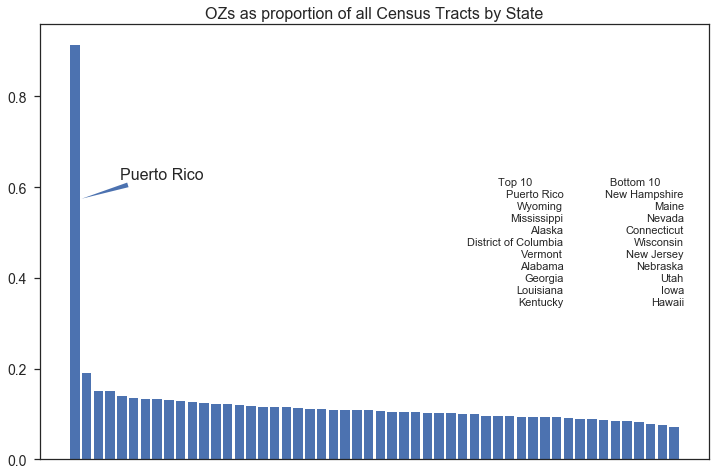

In [486]:
## OZs as proportion of all census tracts in a state
fig, ax = plt.subplots(figsize=(12,8))

p_ozs = state_info['n_ozs'].values / state_info['n_tracts'].values
y = p_ozs[sort_i]
sort_i = np.argsort(p_ozs)[::-1]
x = np.arange(len(p_ozs))

ax.bar(x, y, label = f"Top 10 States : \n {state_info.abbr.values[sort_i][:10]}", color=palette.as_hex()[0])
ax.set_title("OZs as proportion of all Census Tracts by State", fontsize=16)
ax.set_xticks([])
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14)
ax.annotate('Puerto Rico', (40, 260), xytext = (80, 280),\
            xycoords='axes points', arrowprops={'arrowstyle':'wedge'}, fontsize=16)

t = plt.table(cellText=table_text, colLabels=headers, colWidths=[0.18 for i in range(len(table_text))],\
              loc=6, fontsize=14)
ax.add_table(t)

#fig.legend(loc=(10,10))

plt.savefig(f"{images_directory}/ozs_by_states.png", dpi=120)

In [292]:
# Tracts by state w/o Puerto Rico
# fig, ax = plt.subplots(figsize=(12,8))

# ax.bar(x[1:], p_ozs[sort_i][1:])
# ax.set_title("Without Puerto Rico", fontsize=16)
# ax.set_xticks([])
# ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14)

# plt.savefig(f"{images_directory}/ozs_by_state_wo_PR.png", dpi=120)

In [293]:
plotter_features = features.drop(columns=['tract', 'state'])
plotter_features.columns[1]

'age_median'

In [294]:
PR = features[features['state'] == '72']
all_others = features[features['state'] != '72']

In [312]:
us_ = {'household_income_median':63179, 
    'age_median': 38.2,
    'poverty': 0.118,
    'p_black': 0.127,
    'p_white' : 0.730,
    'home_value_median':217600,
    'vacancy': 0.0315}

In [313]:
labels = {}
for f in plotter_features.columns:
    l = f.replace("_", " ").replace('pop ', 'population ')
    l = l.replace("p ", "% ").replace('median', '(median)')
    labels[f] = l
labels

{'population_total': 'population total',
 'age_median': 'age (median)',
 'p_never_married': '% never married',
 'p_white': '% white',
 'p_black': '% black',
 'poverty': 'poverty',
 'household_income_median': 'household income (median)',
 'home_value_median': 'home value (median)',
 'structure_year_median': 'structure year (median)',
 'outofcountyflux': 'outofcountyflux',
 'p_renting': '% renting',
 'vacancy': 'vacancy',
 'p_mobilehomes': '% mobilehomes',
 'p_multiple_unit_strucs': '% multiple unit strucs'}

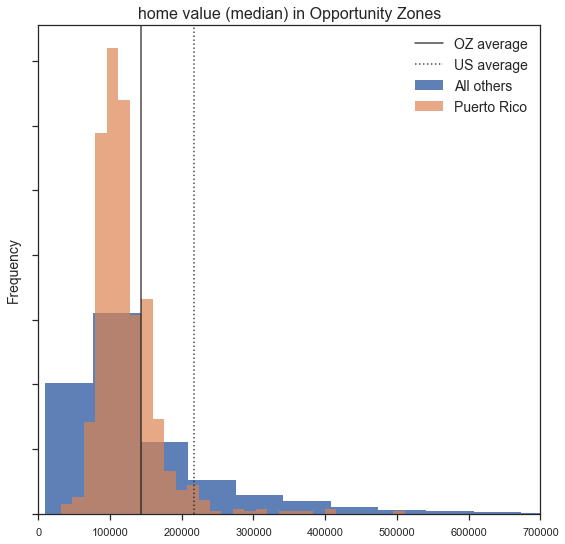

In [504]:
## Demographic plots
#fig, axes = plt.subplots(4, 4, figsize=(30,30))
sns.set_style('ticks')
sns.set_context(rc = {'patch.linewidth': 0.0})

for f in ["home_value_median"]:
    fig, ax = plt.subplots(figsize=(9,9))
    b = 30

    y_PR = PR[f].dropna().values
    y_others = all_others[f].dropna().values
    ax.hist(y_others, bins=b, density=True, alpha=0.9, color=palette.as_hex()[0], label='All others')
    ax.hist(y_PR, bins=b, density=True, alpha=0.7, color=palette.as_hex()[1], label="Puerto Rico")
    
    ax.set_title(f"{labels[f]} in Opportunity Zones", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_yticklabels([])
    if f in us_.keys():
        ax.axvline(np.mean(y_others), linestyle="solid", color='k', alpha=0.8, label="OZ average")
        ax.axvline(us_[f], linestyle="dotted", color='k', alpha=0.8, label="US average")
    if f == "outofcountyflux":
        ax.axvline(np.mean(y_others), linestyle="solid", color='k', alpha=0.8, label="OZ average")
    if f == "home_value_median":
        ax.set_xlim(0, 700000)
    ax.legend(fontsize=14)
    ax.set_facecolor('white')
    
    plt.savefig(f"{demo_dir}/{f}_dist.png", dpi=120)

plt.show()

In [355]:
palette = sns.color_palette(palette='deep')
palette.as_hex()[0]

'#4878d0'

## by LIC status

In [444]:
def add_LIC_col(dataframe):
    LIC_column = pd.read_pickle("{}/qozs_1.pkl".format(data_directory))[['census_tract_number', 'Non-LIC']]
    LIC_column = LIC_column.rename(columns={'census_tract_number':'tract'})
    return dataframe.merge(LIC_column, how='left', on='tract')
features = add_LIC_col(features)

In [473]:
mask = features['Non-LIC'] == 1
LIC = features[mask == False]
nonLIC = features[mask]
nonLIC

,population_total,age_median,p_never_married,p_white,p_black,poverty,household_income_median,home_value_median,structure_year_median,outofcountyflux,p_renting,vacancy,p_mobilehomes,p_multiple_unit_strucs,state,tract,Non-LIC
2,4537.0,43.0,0.235,0.915,0.044,0.149,44985.0,130300.0,1991.0,0.054,0.154,0.173,0.247,0.247,01,01003010400,1
5,5771.0,45.7,0.135,0.917,0.051,0.133,41417.0,148200.0,1990.0,0.044,0.242,0.144,0.045,0.172,01,01003011501,1
70,7438.0,45.0,0.194,0.890,0.075,0.114,53788.0,143300.0,1975.0,0.022,0.062,0.062,0.147,0.156,01,01073011705,1
104,2405.0,45.4,0.207,0.989,0.000,0.173,31278.0,53500.0,1974.0,0.058,0.209,0.153,0.282,0.349,01,01093964500,1
150,7636.0,32.8,0.395,0.580,0.370,0.196,46444.0,141200.0,1980.0,0.073,0.527,0.076,0.014,0.482,01,01125012303,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8448,2937.0,36.3,0.338,0.832,0.016,0.178,38479.0,172500.0,1944.0,0.068,0.432,0.208,0.006,0.379,53,53057952500,1
8497,4303.0,46.6,0.187,1.000,0.000,0.086,54198.0,113800.0,1977.0,0.037,0.147,0.109,0.179,0.183,54,54035963400,1
8524,3127.0,41.4,0.151,0.995,0.001,0.171,41885.0,70100.0,1985.0,0.058,0.202,0.120,0.406,0.412,54,54067950100,1
8538,3314.0,41.9,0.301,0.968,0.005,0.162,35652.0,87800.0,1955.0,0.124,0.486,0.136,0.066,0.326,54,54107011000,1


In [467]:
plotter_features.columns[[3, 5, ]]

Index(['population_total', 'age_median', 'p_never_married', 'p_white',
       'p_black', 'poverty', 'household_income_median', 'home_value_median',
       'structure_year_median', 'outofcountyflux', 'p_renting', 'vacancy',
       'p_mobilehomes', 'p_multiple_unit_strucs'],
      dtype='object')

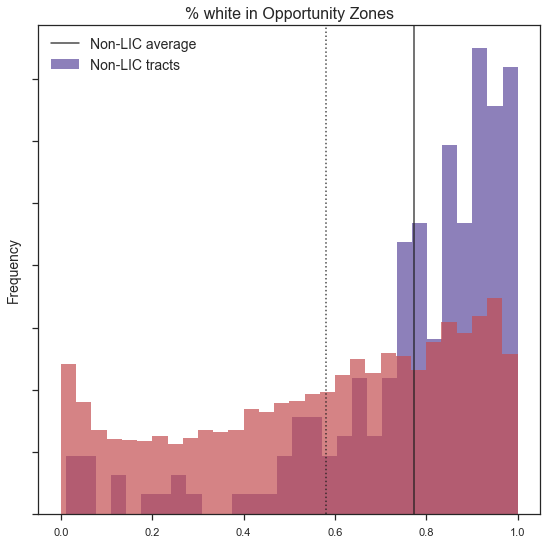

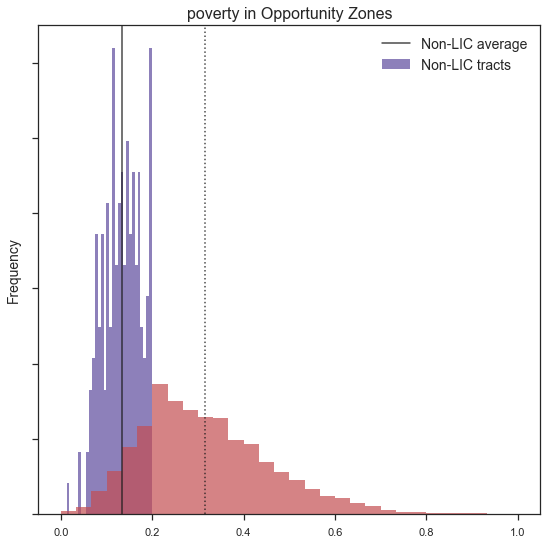

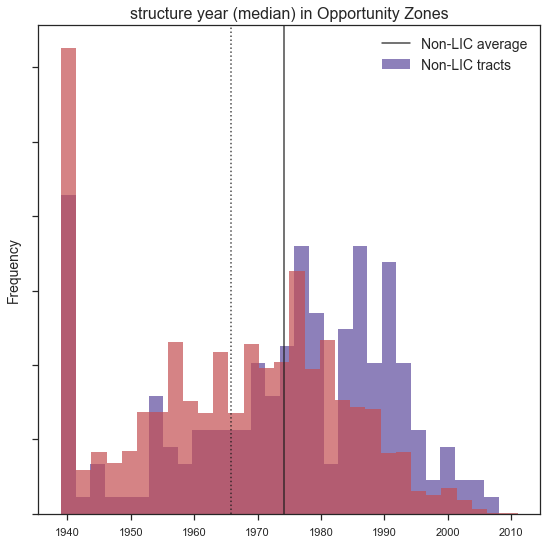

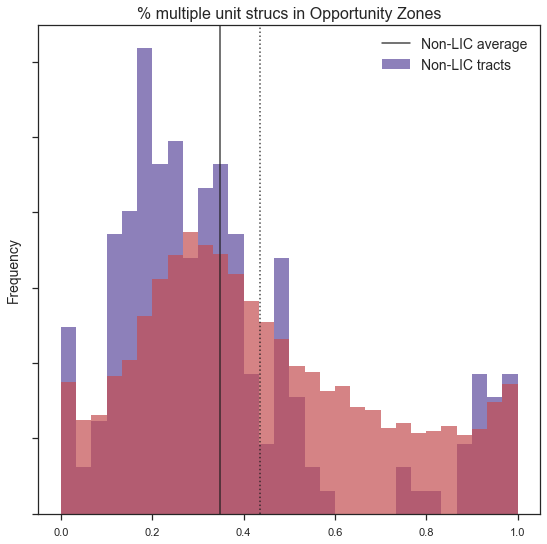

In [489]:
for f in plotter_features.columns[[3, 5, 8, 13]]:
    fig, ax = plt.subplots(figsize=(9,9))
    b = 30

    y_LIC = LIC[f].dropna().values
    y_nonLIC = nonLIC[f].dropna().values
    ax.hist(y_nonLIC, bins=b, density=True, alpha=0.9, color=palette.as_hex()[4], label="Non-LIC tracts")
    ax.hist(y_LIC, bins=30, density=True, alpha=0.7, color=palette.as_hex()[3])
    
    ax.set_title(f"{labels[f]} in Opportunity Zones", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_yticklabels([])
    
    ax.axvline(np.mean(y_nonLIC), linestyle="solid", color='k', alpha=0.8, label="Non-LIC average")
    ax.axvline(np.mean(y_LIC), linestyle="dotted", color='k', alpha=0.8)
    ax.legend(loc='best', fontsize=14)
    ax.set_facecolor('white')
    
    plt.savefig(f"{demo_dir}/{f}_LIC_comp.png", dpi=120)

plt.show()

In [497]:
{'MeanShift', 'KMeans' , 'DBSCAN'}

SyntaxError: invalid syntax (<ipython-input-497-0e61a509d18b>, line 1)